In [2]:
import os
import glob
from pathlib import Path
import pandas as pd
import json
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def get_algorithm(params_path):
    with open(params_path, "r") as f:
        params = []
        for i, l in enumerate(f.readlines()):
            params.append(l)
    # get params
    ssl = [j.split(" ")[1].strip("\n") for j in params if "ssl_task" in j][0]
    return ssl

def get_best_downstream_loss(tb_dir):
    ea = event_accumulator.EventAccumulator(tb_dir)
    ea.Reload()
    try:  
        loss = ea.Scalars('best_downstream_loss__gen_9')[-1].value
        return loss
    except:
        return None
    
def get_data(exp, results):
    chromos = []
    for i, (fitness, chromo) in enumerate(zip(results["pop_vals"], results["chromos"])):
        c = list(chain.from_iterable(chromo[1]))
        c+=[i, exp, fitness[1]]
        chromos.append(c)
    columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
    columns+=["exp_i", "exp", "fitness"]
    columns
    df = pd.DataFrame(chromos, columns=columns)
    
    # create data in long format
    ops = set(list(df["aug1"]) + list(df["aug2"]) +  list(df["aug3"]))
    indexes = {op:i for i, op in enumerate(ops)}
    chromos_long = np.zeros([len(chromos), len(ops)+2])
    exps = []
    for i, c in enumerate(chromos):
        for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
            chromos_long[i][indexes[aug]] = intensity
            chromos_long[i][-1] = c[-1]
            chromos_long[i][-2] = i
        exps.append(exp)
    columns_long = list(ops) + ["exp_i", "fitness"]
    df_long = pd.DataFrame(chromos_long, columns = columns_long)
    df_long['exp'] = exps
    return df, df_long, ops

exps =[f"exp6_{i}" for i in range(4)]+ [f"exp8_{i}" for i in range(4, 8)] + \
        [f"exp10_{i}" for i in range(4)] + [f"exp11_{i}" for i in range(4)]


p = Path('/home/noah/ESSL/cc_experiments/')
dirs = [str(p_i) for p_i in list(p.glob('**'))]
# print(glob.glob(f'/home/noah/ESSL/cc_experiments/*/*/', recursive = True))
csv_map = []
for e in exps: 
    e_dirs = [p_i for p_i in dirs if e == p_i.split("/")[-1]]
    csv_map_i = []
    for e_dir in e_dirs:
        model_dirs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/models"))])
        plot_dirs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/plots"))])
        tbs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/tensorboard"))])
        
        finished_exps = model_dirs.intersection(plot_dirs)
        finished_exps_tbs = finished_exps.intersection(tbs)
        if len(finished_exps) != len(finished_exps_tbs):
            continue
        for f_e in finished_exps:
            csv_map_i.append([e, os.path.basename(f_e), e_dir, f_e])
        
    csv_map+=sorted(csv_map_i, key=lambda x: str(x[1]))
    
columns = ["exp", "seed", "exp_dir", "seed_dir"]
df = pd.DataFrame(csv_map, columns=columns)
df = df.drop_duplicates(["exp", "seed"],keep= 'last')
chromos_df = []
pop_vals_df = []
# display(df["exp"].unique())
for exp in df["exp"].unique():
    exp_df = df[df["exp"] == exp]
    pop_vals = []
    for _, row in exp_df.iterrows():
        outcomes_dir = os.path.join(row["seed_dir"], "outcomes.json")
        algo = get_algorithm(os.path.join(row["seed_dir"], "params.txt"))
        try:
            tb = glob.glob(os.path.join(row["seed_dir"], "tensorboard/*/*.tfevents*" ))[0]
            best_loss = get_best_downstream_loss(tb)
        except:
            best_loss = None
        with open(outcomes_dir, "r") as f:
            outcomes = json.load(f)
            pop_vals+=[[exp, algo, row["seed"], c_val[0], c_val[1], best_loss, i, row["seed_dir"]] for i, c_val in enumerate(outcomes["pop_vals"])]
            cdf,_, ops = get_data(exp, outcomes)
            chromos_df.append(cdf)
    pop_vals_df+=pop_vals
df = pd.DataFrame(pop_vals_df, columns = ["exp", "algo", "seed", "generation", "fitness", "best_loss", "exp_i", "dir"])
# display(df)
# chromo_df = pd.DataFrame(chromos_df, columns=['exp', 'exp_i', 'chromo'])
chromo_df = pd.concat(chromos_df)
df.index = df["exp_i"].astype('str') + "_" + df["exp"]
chromo_df.index = chromo_df["exp_i"].astype('str') + "_" + chromo_df["exp"]
chromo_df = chromo_df.drop(columns=['exp', 'fitness', 'exp_i'])
chromo_df.merge(df, left_index=True, right_index=True)
concat_df = pd.concat([chromo_df, df], axis=1)
# best_final_concat_df = concat_df[concat_df["generation"] == 9].groupby(["exp", "seed", "algo"])["fitness"].max().reset_index(name='fitness').dropna()
# best_final_concat_df
concat_df

,aug1,op1,aug2,op2,aug3,op3,exp,algo,seed,generation,fitness,best_loss,exp_i,dir
0_exp6_0,Solarize,0.969784,Color,1.149277,ShearY,0.009524,exp6_0,NNCLR,0,0,83.070000,0.513013,0,/home/noah/ESSL/cc_experiments/es_figs7/models...
1_exp6_0,ShearY,0.112573,ShearX,0.071512,Contrast,0.524177,exp6_0,NNCLR,0,0,82.070000,0.513013,1,/home/noah/ESSL/cc_experiments/es_figs7/models...
2_exp6_0,VerticalFlip,0.981939,Color,0.443667,Brightness,0.690515,exp6_0,NNCLR,0,0,82.370000,0.513013,2,/home/noah/ESSL/cc_experiments/es_figs7/models...
3_exp6_0,ShearX,0.231855,Brightness,0.690515,VerticalFlip,0.981939,exp6_0,NNCLR,0,0,83.210000,0.513013,3,/home/noah/ESSL/cc_experiments/es_figs7/models...
4_exp6_0,ShearX,0.198554,Sharpness,1.068324,TranslateX,13.000000,exp6_0,NNCLR,0,0,83.230000,0.513013,4,/home/noah/ESSL/cc_experiments/es_figs7/models...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145_exp11_3,VerticalFlip,0.981939,ShearX,0.160904,TranslateX,13.000000,exp11_3,NNCLR,2,9,92.528427,0.302991,145,/home/noah/ESSL/cc_experiments/es_figs11/model...
146_exp11_3,VerticalFlip,0.981939,TranslateX,13.000000,ShearX,0.160904,exp11_3,NNCLR,2,9,92.685925,0.302991,146,/home/noah/ESSL/cc_experiments/es_figs11/model...
147_exp11_3,VerticalFlip,0.778521,TranslateX,14.000000,ShearX,0.191278,exp11_3,NNCLR,2,9,92.685925,0.302991,147,/home/noah/ESSL/cc_experiments/es_figs11/model...
148_exp11_3,VerticalFlip,0.981939,TranslateX,13.000000,ShearX,0.160904,exp11_3,NNCLR,2,9,93.350492,0.302991,148,/home/noah/ESSL/cc_experiments/es_figs11/model...


In [4]:
best_chromos = []
for exp, exp_df in concat_df.groupby(['exp']):    
    edfs = exp_df.sort_values(by="fitness", ascending = False)
    best_chromos.append(list(edfs.iloc[0]))
    display
    # operator_importance(exp_df[['aug1', 'op1', 'aug2', 'op2', 'aug3', 'op3','fitness']], N=50, save_dir=os.path.join(IMP_PLOT_DIR, f"{exp}_{exp_df.iloc[0]['algo']}"))
bc_df = pd.DataFrame(best_chromos, columns=concat_df.columns)
bc_df
bc_df.to_csv("/home/noah/ESSL/exps/Analysis/Final Results/best_chromos/best_chromos.csv")

In [5]:
def gen_palette(df):
    ops = set(list(df["aug1"].unique()) + list(df["aug2"].unique()) + list(df["aug3"].unique()))
    palette = {op:c for op, c in zip(ops, sns.color_palette("hls", len(ops)))}
    return ops, palette
ALL_OPS, PALETTE = gen_palette(concat_df)
PALETTE

{'VerticalFlip': (0.86, 0.3712, 0.33999999999999997),
 'Solarize': (0.86, 0.6312, 0.33999999999999997),
 'ShearX': (0.8287999999999999, 0.86, 0.33999999999999997),
 'TranslateX': (0.5688000000000001, 0.86, 0.33999999999999997),
 'Contrast': (0.33999999999999997, 0.86, 0.3712),
 'Rotate': (0.33999999999999997, 0.86, 0.6312),
 'TranslateY': (0.33999999999999997, 0.8287999999999999, 0.86),
 'Sharpness': (0.33999999999999997, 0.5688000000000001, 0.86),
 'Brightness': (0.3712, 0.33999999999999997, 0.86),
 'HorizontalFlip': (0.6311999999999998, 0.33999999999999997, 0.86),
 'Color': (0.86, 0.33999999999999997, 0.8287999999999999),
 'ShearY': (0.86, 0.33999999999999997, 0.5688000000000001)}

In [6]:
convert = {e:n for e, n in zip(["exp6","exp8", "exp10", "exp11"],
                  ["bs=32, cifar10", "bs=256, cifar10",
                  "bs=256, svhn", "bs=32, svhn"])}

In [7]:
def operator_importance(df, N, save_dir=None):
    df = df.drop(columns=["op1", "op2", "op3"])
    df.columns= ["op1", "op2", "op3", "test acc"]
    df = df.sort_values(by="test acc", ascending=False)
    counts = []
    both = []
    for op in ops:
        c = (df["op1"] == op)[:N].sum() + (df["op2"] == op)[:N].sum() + (df["op3"] == op)[:N].sum()
        counts.append(c)
        both.append([op, c])
    a = [x[1] for x in both]
    both.sort(key=lambda x: x[1], reverse=True)
    both = [[i[0], (float(i[1])-min(a))/(max(a)-min(a))] for i in both]
    palette = [PALETTE[op] for op, _ in both]
    df_entry = {op:imp for op, imp in both}
    sns.barplot(x=[i[1] for i in both], y=[i[0] for i in both], palette=palette)
    # plt.suptitle(f"op importance, {method}")
    if save_dir:
        plt.savefig(save_dir, bbox_inches = 'tight')
    plt.show()
    plt.clf()
    return df_entry

In [8]:
def operator_sensitivity(df, N=50, all_ops=ALL_OPS, save_dir=None):
    chromo_df = df.drop(columns=["op1", "op2", "op3"])
    chromo_df.columns= ["op1", "op2", "op3", "test acc"]
    chromo_df["chromosome"] = [" ".join(ops) for ops in zip(chromo_df["op1"], chromo_df["op2"], chromo_df["op3"])]
    chromo_df = chromo_df.sort_values(by="test acc", ascending=False).iloc[:100]
    # treating order as not important
    cols = ["op1", 
            "op2",
            "op3", ]
    total_similar_accs = {}
    total_similar_chromos = {}
    for op in all_ops:
        
        op_df = chromo_df[(chromo_df[cols]==op).any(axis="columns")]
        similar_accs = []
        similar_chromos = []
        for i, row_i in op_df.iterrows():
            p_i = row_i["test acc"]
            similar_chromos_i = [row_i["chromosome"]]
            # determine which operator contains the gene
            if row_i["op1"] == op:
                operator = "op1"
            if row_i["op2"] == op:
                operator = "op2"
            if row_i["op3"] == op:
                operator = "op3"
            # list of operators that are not op
            other_cols = list(set(cols) - set([operator]))
            avg = 0
            num = 0
            for k, row_k in chromo_df.iterrows():
                if i == k:
                    continue
                if (row_i[operator] not in list(row_k[["op1", "op2", "op3"]])) and \
                (row_i[other_cols[0]] in list(row_k[["op1", "op2", "op3"]])) and \
                (row_i[other_cols[1]] in list(row_k[["op1", "op2", "op3"]])):
                    avg+=row_k["test acc"]
                    num+=1
                    similar_chromos_i.append(row_k["chromosome"])
            if num == 0:
                continue
            similar_accs.append(abs(p_i - (avg/num)))
            similar_chromos.append(similar_chromos_i)
        total_similar_accs[op] = similar_accs
        total_similar_chromos[op] = similar_chromos
    avg_accs = []
    avg_ops = []
    both = []
    missing = []
    for i, op in enumerate(total_similar_accs):
        try:
            avg_accs.append(sum(total_similar_accs[op])/len(total_similar_accs[op]))
            avg_ops.append(op)
            both.append([op, sum(total_similar_accs[op])/len(total_similar_accs[op])])
        except:
            missing.append(op)
    a = [x[1] for x in both]
    both.sort(key=lambda x: x[1], reverse=True)
    both = [[i[0], (float(i[1])-min(a))/(max(a)-min(a))] for i in both] + [[op, 0] for op in missing]
    df_entry = {op:imp for op, imp in both}
    palette = [PALETTE[op] for op, _ in both]
    sns.barplot(y=[x[0] for x in both], x=[x[1] for x in both], palette=palette)
    if save_dir:
        plt.savefig(save_dir, bbox_inches = 'tight')
    plt.show()
    plt.clf()
    return df_entry

'exp10_0'

'SwaV'

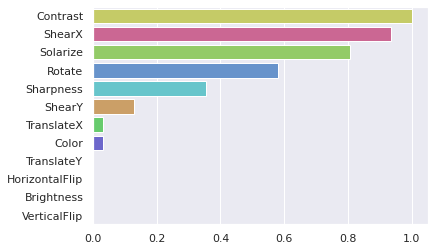

'exp10_1'

'BYOL'

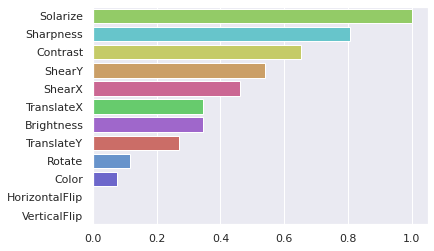

'exp10_2'

'SimSiam'

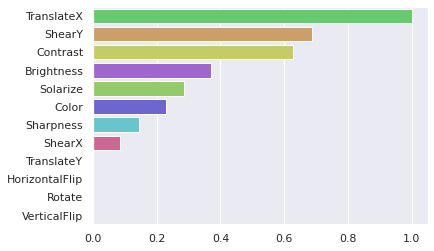

'exp10_3'

'NNCLR'

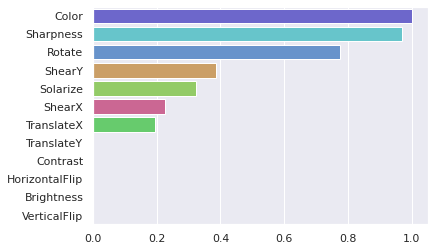

'exp11_0'

'SwaV'

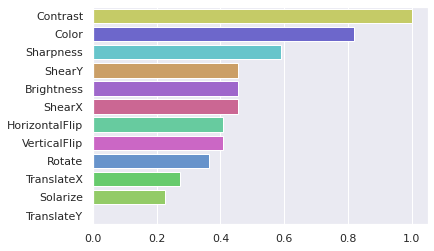

'exp11_1'

'BYOL'

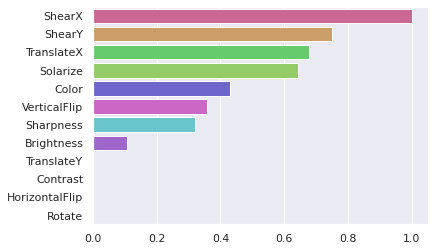

'exp11_2'

'SimSiam'

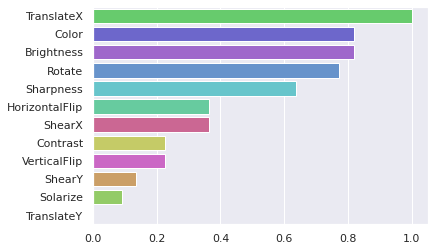

'exp11_3'

'NNCLR'

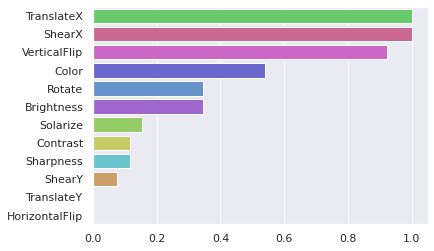

'exp6_0'

'NNCLR'

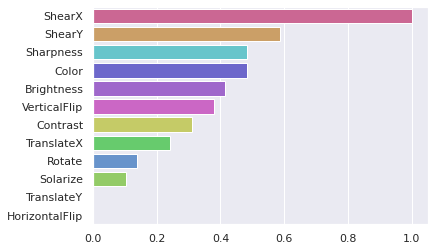

'exp6_1'

'SwaV'

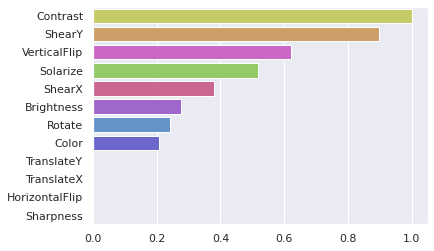

'exp6_2'

'BYOL'

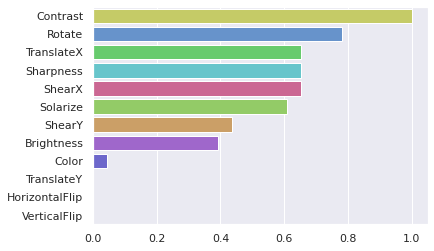

'exp6_3'

'SimSiam'

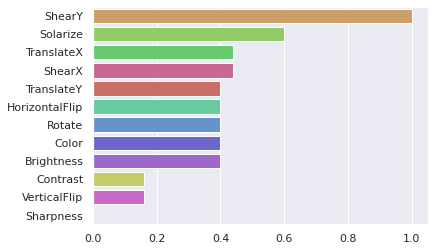

'exp8_4'

'SwaV'

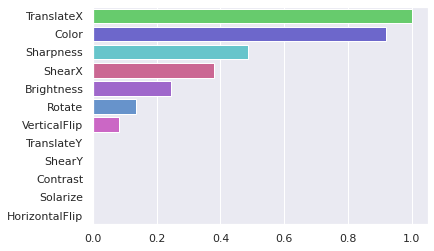

'exp8_5'

'BYOL'

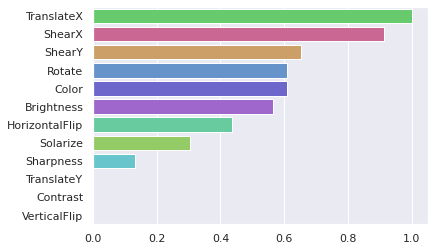

'exp8_6'

'SimSiam'

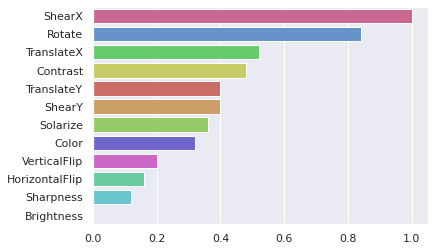

'exp8_7'

'NNCLR'

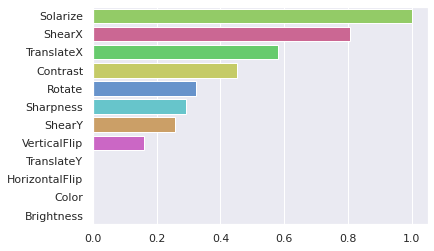

<Figure size 432x288 with 0 Axes>

In [8]:
IMP_PLOT_DIR = "/home/noah/ESSL/exps/Analysis/importance_plots3"
sns.set_theme()
op_imp_outcomes = []
for exp, exp_df in concat_df.groupby(['exp']):    
    display(exp, exp_df.iloc[0]['algo'])
    # get meta vars
    
    # get op imp
    op_imp = operator_importance(exp_df[['aug1', 'op1', 'aug2', 'op2', 'aug3', 'op3','fitness']], N=40, 
                        save_dir=os.path.join(IMP_PLOT_DIR, f"{exp}_{exp_df.iloc[0]['algo']}")
                       )
    
    op_imp['algo'] = exp_df.iloc[0]['algo']
    op_imp['batch size'] = convert[exp.split("_")[0]].split(", ")[0].split("=")[1]
    op_imp['data set'] = convert[exp.split("_")[0]].split(", ")[1]
    op_imp_outcomes.append(op_imp)
outcomes = pd.DataFrame(op_imp_outcomes)
outcomes.to_csv("/home/noah/ESSL/PAPER/results/op_imp_40.csv")

    

BYOL


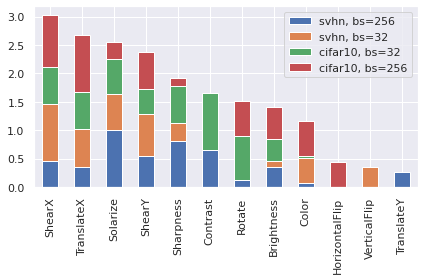

NNCLR


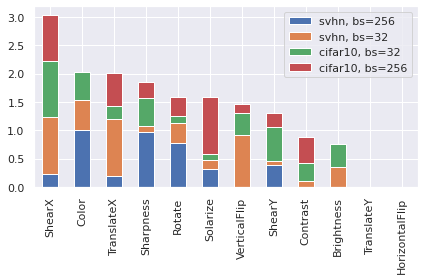

SimSiam


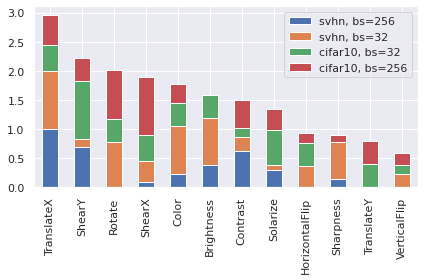

SwaV


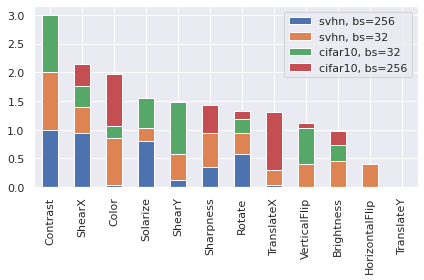

In [9]:
for algo, df in outcomes.groupby('algo'):
    # df.plot( kind='bar', stacked=True)
    print(algo)
    df.index =df['data set'] +', bs='+ df['batch size']
    df = df.drop(columns = ['batch size', 'data set', 'algo'])
    s = df.sum()
    df = df[s.sort_values(ascending=False).index]
    df = df.transpose()   
    df.plot(kind='bar', stacked=True)
    plt.tight_layout()
    plt.savefig(f"/home/noah/ESSL/PAPER/figures/op_imp_plots3/{algo}_stacked.png")
    plt.show()
    


BYOL
NNCLR
SimSiam
SwaV


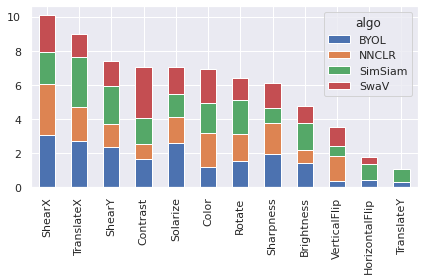

In [10]:
global_ints = []
for algo, df in outcomes.groupby('algo'):
    print(algo)
    df.index =df['data set'] +', bs='+ df['batch size']
    df = df.drop(columns = ['batch size', 'data set', 'algo'])
    s = df.sum().to_dict()
    s['algo'] = algo
    global_ints.append(s)
#     df = df[s.sort_values(ascending=False).index]
#     df = df.transpose()   
#     df.plot(kind='bar', stacked=True)
#     plt.tight_layout()
#     plt.savefig(f"/home/noah/ESSL/PAPER/figures/op_imp_plots/{algo}_stacked.png")
#     plt.show()
global_ints_df = pd.DataFrame(global_ints)
global_ints_df.index = global_ints_df['algo']
global_ints_df = global_ints_df.drop(columns=['algo'])
s = global_ints_df.sum()
global_ints_df = global_ints_df[s.sort_values(ascending=False).index]
global_ints_df.transpose().plot(kind='bar', stacked=True)
plt.tight_layout()
plt.savefig("/home/noah/ESSL/PAPER/figures/op_imp_plots3/all_stacked.png")

In [11]:
SENS_PLOT_DIR = "/home/noah/ESSL/exps/Analysis/sensitivity_plots2"
sns.set_theme()
for exp, exp_df in concat_df.groupby(['exp']):    
    display(exp, exp_df.iloc[0]['algo'])
    operator_sensitivity(exp_df[['aug1', 'op1', 'aug2', 'op2', 'aug3', 'op3','fitness']], save_dir=os.path.join(SENS_PLOT_DIR, f"{exp}_{exp_df.iloc[0]['algo']}"))

'exp10_0'

'SwaV'

KeyboardInterrupt: 

'exp10_0'

'SwaV'

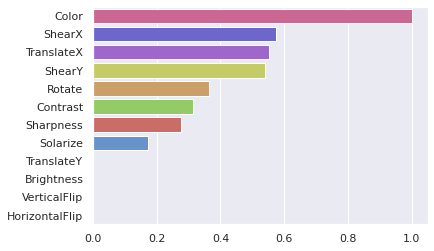

'exp10_1'

'BYOL'

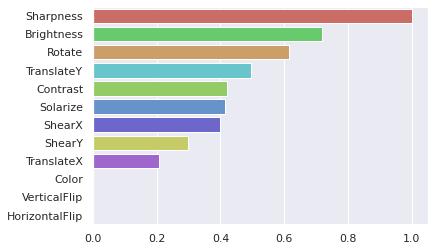

'exp10_2'

'SimSiam'

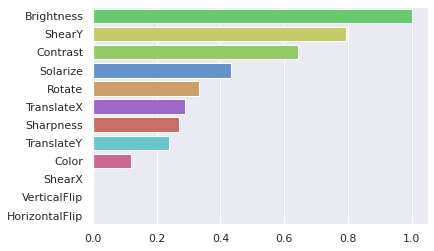

'exp10_3'

'NNCLR'

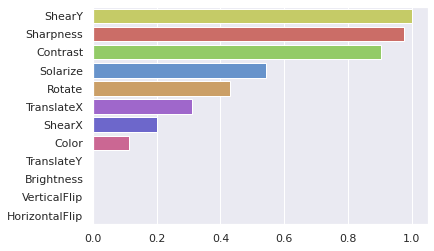

'exp11_0'

'SwaV'

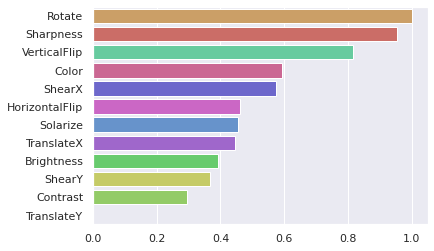

'exp11_1'

'BYOL'

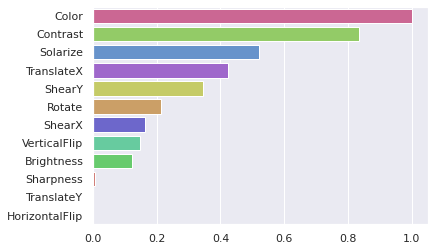

'exp11_2'

'SimSiam'

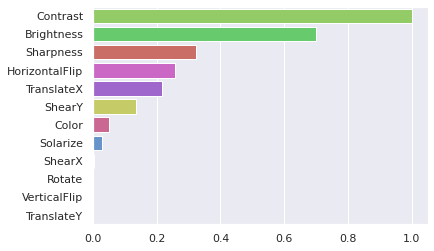

'exp11_3'

'NNCLR'

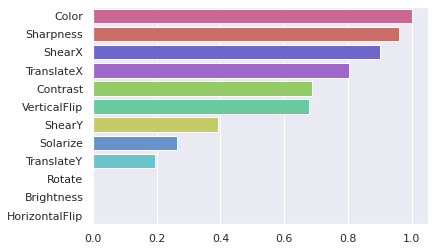

'exp6_0'

'NNCLR'

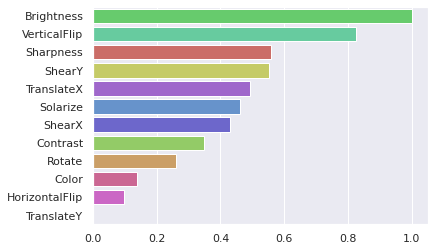

'exp6_1'

'SwaV'

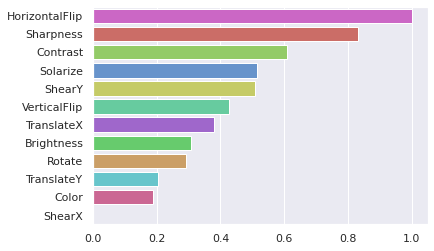

'exp6_2'

'BYOL'

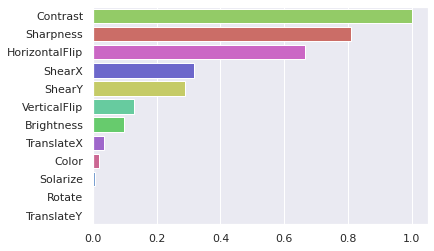

'exp6_3'

'SimSiam'

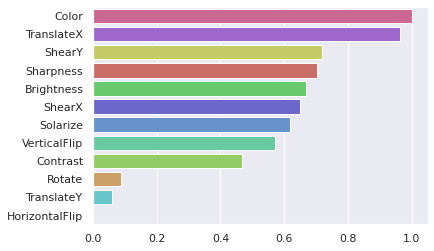

'exp8_4'

'SwaV'

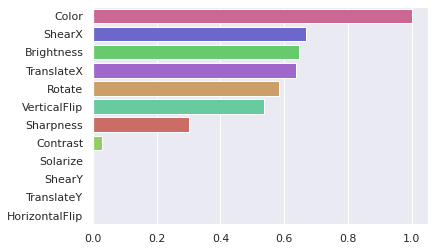

'exp8_5'

'BYOL'

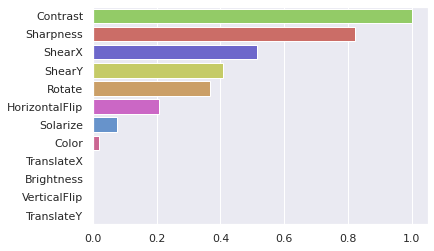

'exp8_6'

'SimSiam'

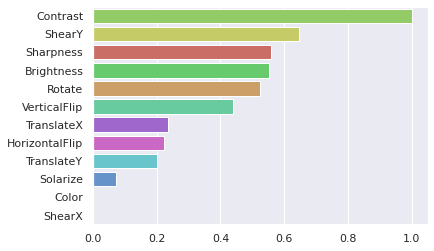

'exp8_7'

'NNCLR'

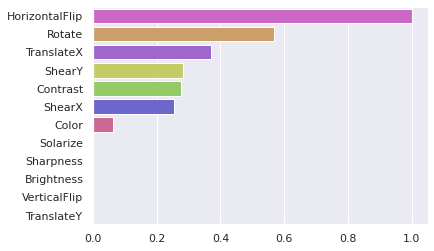

<Figure size 432x288 with 0 Axes>

In [18]:
SENS_PLOT_DIR = "/home/noah/ESSL/exps/Analysis/sensitivity_plots2"
sns.set_theme()
op_sen_outcomes = []
for exp, exp_df in concat_df.groupby(['exp']):    
    display(exp, exp_df.iloc[0]['algo'])
    # get meta vars
    
    # get op imp
    op_sen = operator_sensitivity(exp_df[['aug1', 'op1', 'aug2', 'op2', 'aug3', 'op3','fitness']], N=40, 
                        save_dir=os.path.join(SENS_PLOT_DIR, f"{exp}_{exp_df.iloc[0]['algo']}")
                       )
    
    op_sen['algo'] = exp_df.iloc[0]['algo']
    op_sen['batch size'] = convert[exp.split("_")[0]].split(", ")[0].split("=")[1]
    op_sen['data set'] = convert[exp.split("_")[0]].split(", ")[1]
    op_sen_outcomes.append(op_sen)
outcomes = pd.DataFrame(op_sen_outcomes)
outcomes.to_csv("/home/noah/ESSL/PAPER/results/op_sens.csv")


In [19]:
outcomes


,Color,ShearX,TranslateX,ShearY,Rotate,Contrast,Sharpness,Solarize,TranslateY,Brightness,VerticalFlip,HorizontalFlip,algo,batch size,data set
0,1.000000,0.573485,0.552015,0.538097,0.363286,0.313068,0.274751,0.173018,0.000000,0.000000,0.000000,0.000000,SwaV,256,svhn
1,0.000000,0.400021,0.207370,0.299652,0.615057,0.421161,1.000000,0.415474,0.494591,0.718724,0.000000,0.000000,BYOL,256,svhn
2,0.120505,0.000000,0.287742,0.793866,0.332374,0.642123,0.270136,0.434135,0.239819,1.000000,0.000000,0.000000,SimSiam,256,svhn
3,0.111589,0.200748,0.311648,1.000000,0.430421,0.903405,0.975519,0.542495,0.000000,0.000000,0.000000,0.000000,NNCLR,256,svhn
4,0.592225,0.573254,0.445387,0.368639,1.000000,0.295533,0.954137,0.456258,0.000000,0.393669,0.814421,0.460676,SwaV,32,svhn
5,1.000000,0.162538,0.423434,0.345558,0.214710,0.834875,0.006020,0.521273,0.000000,0.123862,0.148259,0.000000,BYOL,32,svhn
6,0.049183,0.003304,0.217709,0.134227,0.000000,1.000000,0.323914,0.027801,0.000000,0.700634,0.000000,0.256726,SimSiam,32,svhn
7,1.000000,0.899373,0.803327,0.392470,0.000000,0.687337,0.959019,0.263905,0.195343,0.000000,0.677688,0.000000,NNCLR,32,svhn
8,0.137353,0.428364,0.492502,0.551804,0.259984,0.348422,0.557199,0.460822,0.000000,1.000000,0.825683,0.098407,NNCLR,32,cifar10
9,0.189492,0.000000,0.380314,0.508546,0.292138,0.609301,0.832743,0.513250,0.204864,0.307077,0.427542,1.000000,SwaV,32,cifar10


BYOL
NNCLR
SimSiam
SwaV


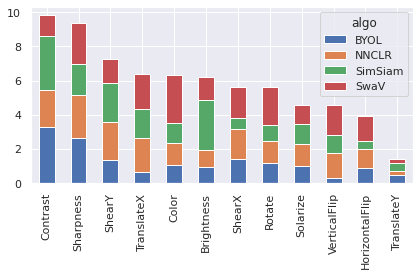

In [20]:
global_ints = []
for algo, df in outcomes.groupby('algo'):
    print(algo)
    df.index =df['data set'] +', bs='+ df['batch size']
    df = df.drop(columns = ['batch size', 'data set', 'algo'])
    s = df.sum().to_dict()
    s['algo'] = algo
    global_ints.append(s)
#     df = df[s.sort_values(ascending=False).index]
#     df = df.transpose()   
#     df.plot(kind='bar', stacked=True)
#     plt.tight_layout()
#     plt.savefig(f"/home/noah/ESSL/PAPER/figures/op_imp_plots/{algo}_stacked.png")
#     plt.show()
global_ints_df = pd.DataFrame(global_ints)
global_ints_df.index = global_ints_df['algo']
global_ints_df = global_ints_df.drop(columns=['algo'])
s = global_ints_df.sum()
global_ints_df = global_ints_df[s.sort_values(ascending=False).index]
global_ints_df.transpose().plot(kind='bar', stacked=True)
plt.tight_layout()
plt.savefig("/home/noah/ESSL/PAPER/figures/op_sens_plots/all_stacked.png")

In [9]:
import torchvision
import PIL
from essl import ops
def get_best_chromo(path, name):
    df, df_long, all_ops = get_data(path)
    # chromo_df = df.drop(columns=["op1", "op2", "op3"])
    #chromo_df.columns= ["op1", "op2", "op3", "test acc"]
   # chromo_df["chromosome"] = [" ".join(ops) for ops in zip(chromo_df["op1"], chromo_df["op2"], chromo_df["op3"])]
    df = df.sort_values(by="test acc")
    return [[df.iloc[-1][f'aug{i}'], df.iloc[-1][f'op{i}']] for i in range(1, 4)]

def gen_augmentation_PIL(chromosome: list) -> torchvision.transforms.Compose:
    # gen augmentation
    # dataloader(augmentation)
    aug = torchvision.transforms.Compose([
        torchvision.transforms.Lambda(ops.__dict__[op](intensity=i))
        for op, i in chromosome
    ])
    return aug

def visualize_chromosome(save_path, chromosome):
    cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", download=True)
    sample = PIL.Image.fromarray(cifar10.data[7])
    sample.save(os.path.join(save_path, "original.jpg"))

    for i in range(num_samples):
        cc = c()
        aug = gen_augmentation_PIL(cc)
        augmented_im = aug(sample)
        augmented_im.save(os.path.join(save_path, f"{i}.jpg"))
    df = pd.DataFrame(chromosomes, columns=[f"op{i}" for i in range(len(chromosomes[0]))])
    df.to_csv(os.path.join(save_path, "chromosomes.csv"))

/home/noah/.conda/envs/essl/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# visualize augs for best chromos (not bs dependent)

In [22]:
from  essl import ops
from collections import defaultdict
chromos = []
save_path = "/home/noah/ESSL/PAPER/figures/vis_augs2"
cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", download=True)
c_10_samples = cifar10.data[7:11]
for i, s in enumerate(c_10_samples):
    sample = PIL.Image.fromarray(s)
    sample.save(os.path.join(save_path, f"original_c10_{i}.jpg"))
svhn = torchvision.datasets.SVHN("datasets/SVHN", download=True)
svhn_samples = [svhn.data[2], svhn.data[16], svhn.data[111], svhn.data[17]]
for i, s in enumerate(svhn_samples):
    sample = PIL.Image.fromarray(s.transpose(1,2,0))
    sample.save(os.path.join(save_path, f"original_svhn_{i}.jpg"))
# b32 + 256Cifar10
# for path, name in zip(b32, b32_names):
#     chromos.append(get_best_chromo(path, name))
#     print(name)
#     best_c = get_best_chromo(path, name)
#     print(best_c)
max_vals = {}
bs = {}

for exp, exp_df in concat_df.groupby(['exp']):
    dataset = convert[exp.split("_")[0]].split(", ")[1]
    best = exp_df.sort_values(by='fitness', ascending=False).iloc[0]
    if dataset+best['algo'] in max_vals:
        if max_vals[dataset+best['algo']]['fitness'] < best['fitness']:
            max_vals[dataset+best['algo']] = best
            bs[dataset+best['algo']] = convert[exp.split("_")[0]].split(", ")[0]
    else:
        max_vals[dataset+best['algo']] = best
        bs[dataset+best['algo']] = convert[exp.split("_")[0]].split(", ")[0]

max_vals = {k:[[df[f'aug{i}'], df[f'op{i}']] for i in range(1, 4)] for k, df in max_vals.items()}

svhn_ims = []
c10_ims = []
rows = []
for k, best_c in max_vals.items():
    if "cifar10" in k:
        for i, s in enumerate(c_10_samples):
            sample = PIL.Image.fromarray(s)
            aug = gen_augmentation_PIL(best_c)
            augmented_im = aug(sample)
            augmented_im.save(os.path.join(save_path, f"{k}_{i}.jpg"))
            row = []      
            for op_i in best_c:
                if 'Flip' in op_i[0]:
                    op_i[1] = 1
                row+=op_i
                print(op_i)
            rows.append(["cifar10", k.strip("cifar10")]+ row)

            
    else:
        for i, s in enumerate(svhn_samples):
            sample = PIL.Image.fromarray(s.transpose(1,2,0))
            aug = gen_augmentation_PIL(best_c)
            augmented_im = aug(sample)
            augmented_im.save(os.path.join(save_path, f"{k}_{i}.jpg"))
            row = []
            for op_i in best_c:
                if 'Flip' in op_i[0]:
                    op_i[1] = 1
                row+=op_i
            rows.append(["svhn", k.strip("svhn")] + row)



Files already downloaded and verified
Using downloaded and verified file: datasets/SVHN/train_32x32.mat
['Sharpness', 0.8848557237234199]
['Contrast', 1.182348184804551]
['ShearX', 0.09833184348662795]
['Sharpness', 0.8848557237234199]
['Contrast', 1.182348184804551]
['ShearX', 0.09833184348662795]
['Sharpness', 0.8848557237234199]
['Contrast', 1.182348184804551]
['ShearX', 0.09833184348662795]
['Sharpness', 0.8848557237234199]
['Contrast', 1.182348184804551]
['ShearX', 0.09833184348662795]
['TranslateX', 8.0]
['Brightness', 0.6905150754934473]
['Color', 0.5025982052759485]
['TranslateX', 8.0]
['Brightness', 0.6905150754934473]
['Color', 0.5025982052759485]
['TranslateX', 8.0]
['Brightness', 0.6905150754934473]
['Color', 0.5025982052759485]
['TranslateX', 8.0]
['Brightness', 0.6905150754934473]
['Color', 0.5025982052759485]
['Contrast', 0.9686110141915404]
['Sharpness', 0.33936066048198305]
['Rotate', -1.0]
['Contrast', 0.9686110141915404]
['Sharpness', 0.33936066048198305]
['Rotate', 

In [17]:
print(rows[0])
opaugcols = []
opaug = [[f'aug{i}', f'op{i}'] for i in range(1, 4)]
for opa in opaug:
    opaugcols+=opa
columns = ['Dataset', 'ssl algorithm'] + opaugcols
print(pd.DataFrame(rows, columns=columns).drop_duplicates().round(decimals=2).to_latex())

['svhn', 'SwaV', 'Color', 1.482108065099183, 'TranslateX', 3.0, 'ShearX', 0.1317252074499123]
\begin{tabular}{llllrlrlr}
\toprule
{} &  Dataset & ssl algorithm &        aug1 &   op1 &          aug2 &   op2 &      aug3 &   op3 \\
\midrule
0  &     svhn &          SwaV &       Color &  1.48 &    TranslateX &  3.00 &    ShearX &  0.13 \\
4  &     svhn &          BYOL &   Sharpness &  0.95 &      Contrast &  1.28 &  Solarize &  0.32 \\
8  &     svhn &       SimSiam &    Contrast &  1.15 &    TranslateX &  5.00 &    ShearY &  0.12 \\
12 &     svhn &         NNCLR &       Color &  0.90 &        ShearY &  0.05 &  Solarize &  0.32 \\
16 &  cifar10 &         NNCLR &   Sharpness &  0.88 &      Contrast &  1.18 &    ShearX &  0.10 \\
20 &  cifar10 &          SwaV &  TranslateX &  8.00 &    Brightness &  0.69 &     Color &  0.50 \\
24 &  cifar10 &          BYOL &    Contrast &  0.97 &     Sharpness &  0.34 &    Rotate & -1.00 \\
28 &  cifar10 &       SimSiam &  TranslateX &  8.00 &  VerticalFlip &

In [14]:
rows

[['svhn',
  'SwaV',
  'Color',
  1.482108065099183,
  'TranslateX',
  3.0,
  'ShearX',
  0.1317252074499123],
 ['svhn',
  'SwaV',
  'Color',
  1.482108065099183,
  'TranslateX',
  3.0,
  'ShearX',
  0.1317252074499123],
 ['svhn',
  'SwaV',
  'Color',
  1.482108065099183,
  'TranslateX',
  3.0,
  'ShearX',
  0.1317252074499123],
 ['svhn',
  'SwaV',
  'Color',
  1.482108065099183,
  'TranslateX',
  3.0,
  'ShearX',
  0.1317252074499123],
 ['svhn',
  'BYOL',
  'Sharpness',
  0.9459531405343823,
  'Contrast',
  1.2753599170758068,
  'Solarize',
  0.32468828442743336],
 ['svhn',
  'BYOL',
  'Sharpness',
  0.9459531405343823,
  'Contrast',
  1.2753599170758068,
  'Solarize',
  0.32468828442743336],
 ['svhn',
  'BYOL',
  'Sharpness',
  0.9459531405343823,
  'Contrast',
  1.2753599170758068,
  'Solarize',
  0.32468828442743336],
 ['svhn',
  'BYOL',
  'Sharpness',
  0.9459531405343823,
  'Contrast',
  1.2753599170758068,
  'Solarize',
  0.32468828442743336],
 ['svhn',
  'SimSiam',
  'Contrast',